# Membuat Sentiment Analysis dari Tweets

## Persiapan Packages

### Install Libraries

Pada pengerjaan ini, ada beberapa packages yang digunakan yaitu:

In [ ]:
!pip install nltk

In [ ]:
!pip install symspellpy

In [ ]:
!pip install spacy

In [ ]:
!pip install Sastrawi

In [ ]:
!pip install swifter

In [ ]:
!pip install wordcloud

In [ ]:
!pip install gensim

In [ ]:
#!pip install flair

### Import Libraries

Pertama, lakukan import library yang dibutuhkan berikut:

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#import libraries
import pandas as pd 
import numpy as np
import string 
import re
import spacy
import ast
import glob
import json
import random
import collections
import datetime
#import lemmatizer as lemma
#import mysql.connector
import pickle
#import pyLDAvis
import nltk
import swifter

%matplotlib inline
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from matplotlib import pyplot as plt
from wordcloud import STOPWORDS
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from operator import itemgetter
from scipy import stats
from datetime import datetime
#from mysql.connector import errorcode

from nltk.corpus import stopwords
import seaborn as sns

# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#import gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from pprint import pprint

Selanjutnya, lakukan download resources dari NLTK untuk proses text processing

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Persiapan Data

**Mengambil Data Tweets periode Sebelum dan Setelah COVID-19**

Lakukan load data tweets dari file CSV di folder Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lakukan import file data tweets dari file CSV di folder Google Drive

In [ ]:
before_covid_df = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/noncovid.csv")
after_covid_df = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/covid.csv")

Lakukan penggabungan data tweets dari kedua periode

In [ ]:
#gabungkan data
#tweet_data = pd.concat([before_covid_df, after_covid_df])
#menghapus unnamed column
#tweet_data = tweet_data.loc[:, ~tweet_data.columns.str.contains('^Unnamed')]
#menghapus duplicat kolom
#tweet_data=tweet_data.loc[:, ~tweet_data.columns[::-1].duplicated()[::-1]]

#print("Jumlah Data: ", len(tweet_data))

## Text Processing

**Melakukan Case Folding**

*Case folding* bertujuan untuk mengubah semua huruf dalam sebuah dokumen teks menjadi huruf kecil (lowercase)

In [ ]:
# gunakan fungsi Series.str.lower() pada Pandas
def case_folding(tweet_data_df):
    #tweet_data_df['tweet_char'] = tweet_data_df['tweet_tokens_lemma'].str.lower()
    tweet_data_df['tweet_char'] = tweet_data_df['tweet'].str.lower()
    
    return tweet_data_df

**Menghapus Spesial Karakter**

Proses ini digunakan untuk menghapus number, link, punctuation, single char, space, entities, mention, hastag dan karakter spesial lain.

In [ ]:
def remove_tweet_special(text):
    # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove incomplete URL
    text = text.replace("http://", " ").replace("https://", " ")
    # Remove every retweet symbol
    text = re.sub('(?i)rt',' ',text)
    # Remove every username
    text = re.sub('@[^\s]+[ \t]','',text)
     # Remove every username
    text = re.sub('(?i)user','',text)
    # Remove every url
    text = re.sub('(?i)url',' ',text)
    # Remove every emoji
    text = re.sub(r'\\x..',' ',text)
    # Remove extra spaces
    text = re.sub('  +', ' ', text)
    #Remove characters repeating more than twice
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) 
    
    return text

def strip_links(text):
    # remove link
    text = re.sub(r'pic.twitter.com.[\w]+', '', text) # Remove every pic 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ', text)
    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def special_char(tweet_data_df):
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_tweet_special)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(strip_links)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(strip_all_entities)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_number)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_punctuation)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_whitespace_LT)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_whitespace_multiple)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_singl_char)
    
    return tweet_data_df

**Tokenizing**

*Tokenizing* adalah operasi memisahkan teks menjadi potongan-potongan berupa token, bisa berupa potongan huruf, kata, atau kalimat, sebelum dianalisis lebih lanjut. Entitas yang bisa disebut sebagai token misalnya kata, angka, simbol, tanda baca, dan lain sebagainya

In [ ]:
# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)
    
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

def tokenizing(tweet_data_df):
    #tweet_data_df['tweet_tokens'] = tweet_data_df['tweet'].apply(word_tokenize_wrapper)
    tweet_data_df['tweet_tokens'] = list(sent_to_words(tweet_data_df['tweet_char']))
    tweet_data_df['tweet_tokens'] = make_n_grams(tweet_data_df['tweet_tokens'])
    
    return tweet_data_df

**Filtering (Stopword Removal)**

Menghilangkan kata umum (*common words*) yang biasanya muncul dalam jumlah besar dan dianggap tidak memiliki makna.

In [ ]:
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')

# append additional stopword
#list_stopwords.extend(['test'])

# read txt stopword using pandas

txt_stopword1 = pd.read_csv("/content/drive/MyDrive/Thesis/resources/stopwords/stopwords.txt", names= ["stopwords"], header = None)
txt_stopword2 = pd.read_csv("/content/drive/MyDrive/Thesis/resources/stopwords/stopword2.txt", names= ["stopwords"], header=None)
txt_stopword3 = pd.read_csv("/content/drive/MyDrive/Thesis/resources/unimportant text/unimportant-text.txt", names= ["stopwords"], header=None)
txt_stopword4 = pd.read_csv("/content/drive/MyDrive/Thesis/resources/stopwords/stopwords4.csv", names= ["stopwords"], header = None)
txt_stopword5 = pd.read_csv("/content/drive/MyDrive/Thesis/resources/unimportant text/other-unimportant-text.txt", names= ["stopwords"], header=None)

txt_stopword1 = txt_stopword1["stopwords"][0].split(' ')
txt_stopword2 = txt_stopword2["stopwords"][0].split(' ')
txt_stopword3 = txt_stopword3["stopwords"][0].split(' ')
txt_stopword4 = txt_stopword4["stopwords"][0].split(' ')
txt_stopword5 = txt_stopword5["stopwords"][0].split(' ')
        
# convert stopword string to list & append additional stopword
list_stopwords.extend(txt_stopword1)
list_stopwords.extend(txt_stopword2)
list_stopwords.extend(txt_stopword3)
list_stopwords.extend(txt_stopword4)
list_stopwords.extend(txt_stopword5)

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    #words = ast.literal_eval(words)
    
    #filtered_sentence = [word for word in words if not word in list_stopwords]
    filtered_sentence = [] 
    
    for word in list(words):
        tokens = words
        
        if len(tokens)> 1:
            for token in list(tokens):
                if token not in list_stopwords: 
                    filtered_sentence.append(token) 
            
        else:
            if word not in list_stopwords: 
                filtered_sentence.append(word) 
    
    return filtered_sentence
        
#function
def stopwords_process_first(tweet_data_df):
    tweet_data_df['tweet_tokens'] = (tweet_data_df['tweet_tokens'].apply(stopwords_removal))

def stopwords_process_second(tweet_data_df):
    tweet_data_df['tweet_final_tokens'] = (tweet_data_df['tweet_tokens_stemmed'].apply(stopwords_removal))

    return tweet_data_df

**Normalization**

Normalization digunakan untuk menyeragamkan term yang memiliki makna sama namun penulisanya berbeda, bisa diakibatkan kesalahan penulisan, penyingkatan kata, ataupun “bahasa gaul”.

In [ ]:
#file1
normalizad_word1 = pd.read_csv("/content/drive/MyDrive/Thesis/resources/slang words/colloquial-indonesian-lexicon.txt")
#file2
normalizad_word2 = pd.read_csv("/content/drive/MyDrive/Thesis/resources/slang words/kamusalay.csv", header=None)
#file3
file = open("/content/drive/MyDrive/Thesis/resources/slang words/combined_slang_words.txt", "r")
contents = file.read()
normalizad_word3 = ast.literal_eval(contents)
file.close()
#file4
normalizad_word4 = pd.read_csv("/content/drive/MyDrive/Thesis/resources/slang words/kamusalay.csv", header=None)
#file5
normalizad_word5 = pd.read_csv('/content/drive/MyDrive/Thesis/resources/slang words/kbba.txt', sep="\t", header=None)

normalizad_word_dict = {}

for index, row in normalizad_word1.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 
        
for index, row in normalizad_word2.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 
        
for index in normalizad_word3.keys():
    if index not in normalizad_word_dict:
        normalizad_word_dict[index] = normalizad_word3[index]

for index, row in normalizad_word4.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]
        
for index, row in normalizad_word5.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

def normalization(tweet_data_df):
    tweet_data_df['tweet_normalized'] = tweet_data_df['tweet_tokens'].swifter.apply(normalized_term)
    
    return tweet_data_df

**Stemming**

Function stemmer dari library Sastrawi untuk mengembalikan kata kebentuk dasarnya. Karena fungsi stemmer.stem() pada library Sastrawi lambat, kita dapat menggunakan library swifter untuk mempercepat froses stemming pada Dataframe dengan menjalankan task secara parallel. Kecepatan pemrosesan bisa dua kali bahkan lebih cepat jika tanpa menggunakan swifter.

In [ ]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

def stemming(tweet_data_df):
    for document in tweet_data_df['tweet_normalized']:
        for term in document:
            if term not in term_dict:
                term_dict[term] = ' '

    for term in term_dict:
        term_dict[term] = stemmed_wrapper(term)
        #print(term,":" ,term_dict[term])

    tweet_data_df['tweet_tokens_stemmed'] = tweet_data_df['tweet_normalized'].swifter.apply(get_stemmed_term)
    #print(tweet_data_df['tweet_tokens_stemmed'])

    return  tweet_data_df

## Pemilihan Data

**Eksekusi Text Processing** 

In [ ]:
import os

def text_processing(tweet_data_df):
    
    # memanggil function untuk text processing
    case_folding_result = case_folding(tweet_data_df)
    special_char_result = special_char(case_folding_result)
    tokenizing_result = tokenizing(case_folding_result)
    normalization_result = normalization(tokenizing_result)
    stopwords_first_result = stopwords_process_first(normalization_result)
    stemming_result = stemming(normalization_result)
    stopwords_second_result = stopwords_process_second(stemming_result)
        
    return (stopwords_second_result)

### Pemanggilan Fungsi Text Processing

In [ ]:
tweet_data_df = after_covid_df.copy()
#tweet_data_df = before_covid_df.copy()

In [ ]:
#tweet_data_df['tweet_tokens_lemma'] = tweet_data_df['tweet_tokens_lemma'].str.replace("'","")
#tweet_data_df['tweet_tokens_lemma'] = tweet_data_df['tweet_tokens_lemma'].str.replace("]","")
#tweet_data_df['tweet_tokens_lemma'] = tweet_data_df['tweet_tokens_lemma'].str.replace("]","")
#tweet_data_df['tweet_tokens_lemma'] = tweet_data_df['tweet_tokens_lemma'].str.replace(",","")

In [ ]:
tweet_data_final_df = text_processing(tweet_data_df)

Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7333 [00:00<?, ?it/s]

In [ ]:
tweet_data_df

,Unnamed: 0,tweet_id,username,date,time,tweet,replies_count,likes_count,retweets_count,period,tweet_tokens_lemma,tweet_tokens_final,topic_predict,cluster,tweet_char,tweet_tokens,tweet_normalized,tweet_tokens_stemmed,tweet_final_tokens
0,20450,1243759409391517696,3le4n012,2020-03-28,04:38:45,@xojolx Ane lagi nunggu ini bang dirumah 🙏🏿👌,0,0.0,0.0,covid,"['tunggu', 'rumah']",['rumah'],6,3,ane lagi nunggu ini bang dirumah,"[ane, nunggu, dirumah, ane, nunggu, dirumah, a...","[ane, lagi, menunggu, ini, bang, dirumah]","[ane, lagi, tunggu, ini, bang, rumah]","[ane, rumah, ane, rumah, ane, rumah, ane, ruma..."
1,20451,1243078717930213376,3le4n012,2020-03-26,07:33:56,@ARTventureCo @olenksg Dah lah bunuh diri ajah...,0,0.0,0.0,covid,['bunuh'],['bunuh'],18,3,ventureco dah lah bunuh diri ajah akoh,"[ventureco, bunuh_diri, ajah, akoh, ventureco,...","[ventureco, deh, lah, bunuh_diri, saja, aku]","[ventureco, deh, lah, bunuh diri, saja, aku]","[ventureco, bunuh diri, ventureco, bunuh diri,..."
2,20452,1243063269763379200,3le4n012,2020-03-26,06:32:33,"@tamikecil Dah lah, bunuh diri ajah😩 https://...",0,0.0,0.0,covid,['bunuh'],['bunuh'],18,3,dah lah bunuh diri ajah,"[bunuh_diri, ajah, bunuh_diri, ajah, bunuh_dir...","[deh, lah, bunuh_diri, saja]","[deh, lah, bunuh diri, saja]","[bunuh diri, bunuh diri, bunuh diri, bunuh diri]"
3,20453,1243003994118578176,3le4n012,2020-03-26,02:37:00,Doakan kami tetap baik2 saja🙏🏿🙏🏿🙏🏿,1,0.0,0.0,covid,['doa'],['doa'],8,3,doakan kami tetap baik saja,"[doakan, doakan, doakan, doakan, doakan]","[doakan, kami, tetap, baik, saja]","[doa, kami, tetap, baik, saja]","[doa, doa, doa, doa, doa]"
4,20454,1242682361751330816,3le4n012,2020-03-25,05:18:57,@fikriqq Guru BK nyuruh beliin gorengan di kantin,0,0.0,0.0,covid,"['guru', 'buku', 'suruh', 'beli', 'goreng', 'k...","['guru', 'buku', 'kantin']",6,3,guru bk nyuruh beliin gorengan di kantin,"[guru, nyuruh, beliin, gorengan, kantin, guru,...","[guru, bk, nyuruh, membelikan, gorengan, di, k...","[guru, bk, nyuruh, beli, goreng, di, kantin]","[guru, nyuruh, kantin, guru, nyuruh, kantin, g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7328,16979,1264984780971507712,yuliani2907,2020-05-25,18:20:48,Tbh gue lebih milih ga on twitter dan sadar di...,1,0.0,0.0,covid,"['jujur', 'pilih', 'sadar diri', 'twitter', 'i...",['twitter'],18,3,tbh gue lebih milih ga on twitter dan sadar di...,"[tbh, milih, twitter, kepo, liat, twitter, isi...","[tbh, saya, lebih, memilih, enggak, on, twitte...","[tbh, saya, lebih, pilih, enggak, on, twitter,...","[tbh, twitter, ingin tahu, twitter, konten, bu..."
7329,16980,1264594331983155200,yuliani2907,2020-05-24,16:29:18,"Bajrangi Bhaijan ga bosen"" buat di tonton 😊",1,0.0,0.0,covid,"['bosan', 'tonton']",['bosan'],5,3,bajrangi bhaijan ga bosen buat di tonton,"[bajrangi, bhaijan, bosen, bajrangi, bhaijan, ...","[bajrangi, bhaijan, enggak, bosan, buat, di, t...","[bajrangi, bhaijan, enggak, bosan, buat, di, t...","[bajrangi, bhaijan, bosan, bajrangi, bhaijan, ..."
7330,16981,1264221571461246976,yuliani2907,2020-05-23,15:48:05,ㅋㅋㅋㅋㅋ mreka mau foto apa mau pamer HP 😂,1,0.0,0.0,covid,"['pamer', 'handphone']",['handphone'],0,0,mreka mau foto apa mau pamer hp,"[mreka, hp, mreka, hp, mreka, hp, mreka, hp, m...","[mereka, mau, foto, apa, mau, pamer, hp]","[mereka, mau, foto, apa, mau, pamer, hp]","[hp, hp, hp, hp, hp, hp, hp]"
7331,16982,1264158966747000832,yuliani2907,2020-05-23,11:39:19,"@Maliana23 Bukan aneh si lebih tepatnya kamal,...",1,0.0,0.0,covid,"['aneh', 'tepat', 'kamal', 'sesak', 'lebaran',...","['kamal', 'sesak', 'lebaran', 'rumah']",6,3,bukan aneh si lebih tepatnya kamal lebih ngera...,"[tepatnya, kamal, ngerasa, nyesek, lebaran, di...","[bukan, aneh, sih, lebih, tepatnya, kamal, leb...","[bukan, aneh, sih, lebih, tepat, kamal, lebih,...","[kamal, sesak, lebaran, rumah, kamal, sesak, l..."


# LDA Model

In [ ]:
data_input = tweet_data_final_df['tweet_final_tokens'].copy()
#data_input = data_input.str.split(',')
#data_input = data_input.replace(',','', regex=True)
#data_input = data_input.str.split()
data_input = data_input.tolist()

In [ ]:
id2word = corpora.Dictionary(data_input)
texts = data_input
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

[(0, 6), (1, 6)]


In [ ]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

In [ ]:
from pprint import pprint

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Build LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.244*"tidur" + 0.096*"sakit" + 0.090*"lebaran" + 0.062*"covid" + '
  '0.040*"video" + 0.031*"minggu" + 0.028*"ira" + 0.019*"berani" + '
  '0.015*"sesak" + 0.011*"stres"'),
 (1,
  '0.266*"rumah" + 0.066*"sedih" + 0.055*"malas" + 0.039*"pasar" + '
  '0.034*"pasien" + 0.021*"mandi" + 0.014*"pe ama" + 0.014*"ingin tahu" + '
  '0.012*"boros" + 0.012*"masakan"'),
 (2,
  '0.126*"makan" + 0.121*"puasa" + 0.049*"hp" + 0.046*"harga" + '
  '0.046*"indonesia" + 0.041*"kamar" + 0.040*"rakyat" + 0.040*"lockdown" + '
  '0.027*"dokter" + 0.026*"gila"'),
 (3,
  '0.064*"bahagia" + 0.049*"twitter" + 0.048*"mati" + 0.040*"kantor" + '
  '0.039*"jokowi" + 0.036*"terima kasih" + 0.031*"tiktok" + 0.028*"tugas" + '
  '0.026*"konser" + 0.025*"wabah"'),
 (4,
  '0.144*"corona" + 0.131*"masker" + 0.077*"perintah" + 0.071*"sahur" + '
  '0.060*"anak" + 0.028*"psbb" + 0.026*"youtuber" + 0.018*"kos" + '
  '0.015*"sebar" + 0.014*"kota"'),
 (5,
  '0.052*"wfh" + 0.045*"online" + 0.034*"marah" + 0.033*"sampah" + 

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_input, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\\nCoherence Score: ', coherence_lda)

\nCoherence Score:  0.6282057029697807


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, 
                        num_topics=num_topics, 
                        id2word=id2word,
                        random_state=0,
                        chunksize=100,
                        alpha='auto',
                        per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_input, start=2, limit=40, step=4)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_input, start=2, limit=100, step=2)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


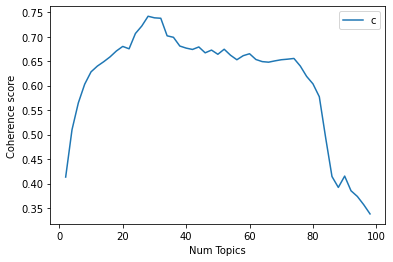

In [ ]:
# Show graph
limit=100; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \\
of {coherence_values[best_result_index]}''')

The 28 topics gives the highest coherence score \of 0.7418328373541153


In [ ]:
import pickle

open_file = open('/content/drive/MyDrive/Thesis/Model/Topic Modeling/10012022_before_covid_100_lda_edited.pkl', "wb")
pickle.dump(coherence_values, open_file)
open_file.close()

In [ ]:
import pickle

open_file = open('/content/drive/MyDrive/Thesis/Model/Topic Modeling/10012022_before_covid_100_lda_edited.pkl', "rb")
loaded_list1 = pickle.load(open_file)
open_file.close()

In [ ]:
import pickle

open_file = open('/content/drive/MyDrive/Thesis/Model/Topic Modeling/10012022_before_covid_100_lda_edited.pkl', "rb")
before_covid = pickle.load(open_file)
open_file.close()

open_file = open('/content/drive/MyDrive/Thesis/Model/Topic Modeling/10012022_after_covid_100_lda_edited.pkl', "rb")
after_covid = pickle.load(open_file)
open_file.close()

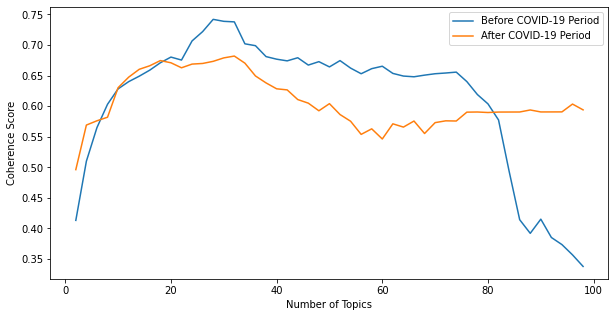

In [ ]:
# Show graph
plt.figure(figsize=(10, 5))
limit=100; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, before_covid, label = 'Before COVID-19 Period')
plt.plot(x, after_covid, label = "After COVID-19 Period")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(loc='best')
plt.show()

In [ ]:
bestModel = LdaModel(corpus=corpus, 
                        #num_topics=28,
                        num_topics=32, 
                        id2word=id2word,
                        random_state=0,
                        chunksize=100,
                        alpha='auto',
                        per_word_topics=True
                        )

In [ ]:
bestModel.save('/content/drive/MyDrive/Thesis/Model/Topic Modeling/07022022_32_topic_after_covid_lda.model')

In [ ]:
#loadModel.load('/content/drive/MyDrive/Thesis/Model/Topic Modeling/2112021_52_lda.model')